In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import dia_matrix
from scipy.sparse.linalg import spsolve 

from IPython.display import clear_output

plt.rcParams['figure.figsize'] = [9,5] #globally set figure size
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.style.use('seaborn-whitegrid')

### Stochastic Volatility Model
For the hidden process,
$$
X_n = \mu +\alpha(X_{n-1}-\mu)+\sigma\epsilon_n,\qquad X_0\sim\mathsf{N}(\mu,\sigma^2/(1-|\alpha|^2))
$$

So

$$
\log p(x_{0}) = -\frac{1-|\alpha|^2}{2\sigma^2}(x_0-\mu)^2 + \text{const.}
$$

$$
\log p(x_{n}|x_{n-1}) = -\frac{1}{2\sigma^2}[x_n-\alpha x_{n-1}-\mu(1-\alpha)]^2 + \text{const.}
$$

and 

$$
\log p(x_{0:n-1}) = -\frac{1}{2\sigma^2}(x_{0:n-1}-\mu\mathbf{1})^T\Sigma^{-1}(x_{0:n-1}-\mu\mathbf{1}) + \text{const.},
$$
where $x_{0:n-1}$ is a vector and $\Sigma^{-1}$ is a tri-diagonal.

For the observations:
$$
Y_n\sim \mathsf{N}(0,\exp(X_n))
$$

so 

$$
\log p(y_n|x_n) = - \frac{1}{2}[x_n+y_n^2\exp(-x_n)] + \text{const.}
$$

$$
\log p(y_{0:n-1}|x_{0:n-1}) = -\frac{1}{2}\left[\sum_i x_i + \sum_i y_i^2\exp(-x_i) \right]
$$


In [ ]:
#simulate data
sim_data = 1
n_obs = 500
alpha_true = 0.9
mu_true = 0
sigma_true = 0.1

x_true = np.zeros(n_obs)
y = np.zeros(n_obs)

x_true[0] = mu_true + np.random.randn() * sigma_true / (1-alpha_true**2)**0.5
y[0] = np.random.randn() * np.exp(x_true[0]/2)

for i in range(1,n_obs):
    x_true[i] = mu_true + alpha_true*(x_true[i-1] - mu_true) + sigma_true*np.random.randn()
    y[i] = np.random.randn() * np.exp(x_true[i]/2)
    


In [3]:
#or load data in the form of residuals from a Fama-French model
sim_data = 0
y = np.loadtxt("residuals_monthly.csv", delimiter=",")

n_obs = y.size
alpha_true = 0.25
mu_true = 0
sigma_true = 1.75

<IPython.core.display.Javascript object>


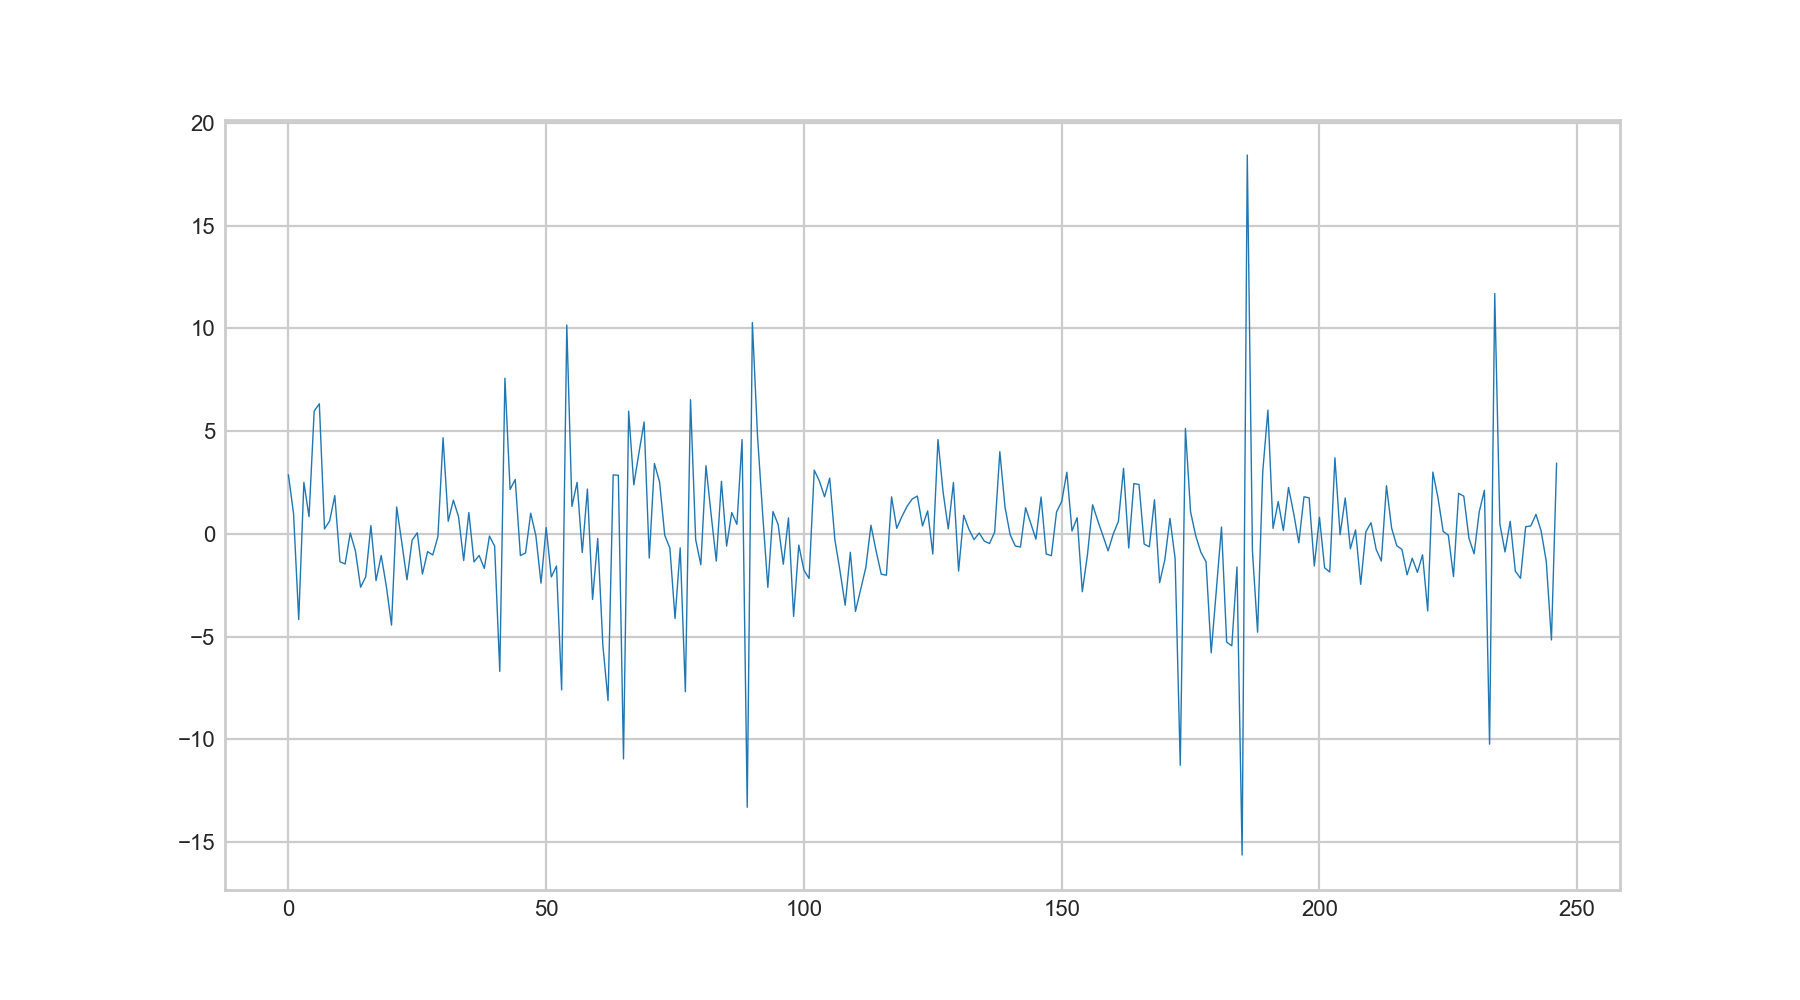

In [4]:
fig1, ax = plt.subplots()

ax.plot(range(n_obs), y, linewidth=0.5)
if sim_data == 1: #plot the true 2\sigma interval
    ax.fill_between(range(n_obs), -2*np.exp(x_est_opt/2), 2*np.exp(x_est_opt/2), alpha=0.3, facecolor='red')

### Gradient and Hessian for use in Newton's method
The idea use to Newton's method to minimize:
$$
U(x_{0:n}) = - \log p(x_{0:n},y_{0:n}),
$$
where the parameters $\alpha,\mu,\sigma$ are not shown in the notation. 

Gradient of $U$ is calculated from:

$$
\nabla_{x_{0:n}} \log p(x_{0:n})= -\Sigma^{-1}(x_{0:n}-\mu\mathbf{1}),\qquad\nabla_{x_m} \log p(y_{0:n}|x_{0:n})= -\frac{1}{2}+\frac{1}{2}y_m^{2}\exp(-x_m).
$$

Hessian of $U$ is:
    
$$
\Sigma^{-1}+\frac{1}{2}\text{diag}\{y_1^2 e^{-x_0},\cdots,y_n^2 e^{-x_n}\}.
$$

Note $U$ is strongly-convex and the Hessian is tri-diagonal, so it can be stored efficiently as a sparse matrix and the cost of a single Newton step scales lineary in $n$. 

In [5]:
def build_inv_cov(n_obs,alpha,sigma):

    data = np.ones((3,n_obs))
    data[0,1:n_obs] = - alpha * np.ones((1,n_obs-1)) #first above diagonal - check sign!!
    data[1,1:n_obs-1] = data[1,1:n_obs-1] + alpha**2 *np.ones(n_obs-2)
    data[2,0:n_obs-1] = - alpha * np.ones((1,n_obs-1))   #first below diagonal
    
    offsets = [1,0,-1]
    
    inv_cov = sigma**(-2) * dia_matrix((data, offsets), shape=(n_obs, n_obs))
    
    return inv_cov #NB this returns matrix in sparse dia_matrix format

In [6]:
def eval_grad_U(x,y,mu,inv_cov,n_obs):
    
    grad = inv_cov @ (x-mu) + 0.5*np.ones(n_obs) - 0.5 * np.multiply(np.power(y,2) , np.exp(-x))
    
    return grad

In [7]:
def eval_hess_U(x,y,inv_cov,n_obs):
    
    data = 0.5 * np.multiply(np.power(y,2) , np.exp(-x))
    offsets = [0]
    like_hess = dia_matrix((data, offsets), shape=(n_obs, n_obs))
    hess = inv_cov + like_hess
    
    return hess

In [8]:
#estimate parameters of an AR(1) process
def est_params(x):
    mu = np.mean(x)
    var_stat = np.var(x)
    alpha = np.mean((x[1:]-mu) * (x[:x.size -1 ]-mu)) / var_stat
    sigma = np.var(x[1:]-alpha*x[:x.size-1])**0.5
     
    return alpha, mu, sigma

## Newton's method

In [10]:
if sim_data == 1:
    alpha = alpha_true
    mu = mu_true
    sigma = sigma_true
else:
    #alpha, mu, sigma = est_params(np.log(np.power(y,2))) #guess some parameter values based on the data
    alpha = 0.9
    mu = 0
    sigma = 1
    
inv_cov = build_inv_cov(n_obs, alpha, sigma)

x_now = np.zeros(n_obs)
n_steps = 10
grad_norm = np.zeros(n_steps)

for i in range(n_steps):
    grad = eval_grad_U(x_now,y,mu,inv_cov,n_obs)
    hess = eval_hess_U(x_now,y,inv_cov,n_obs)
    grad_norm[i] = np.dot(grad,grad)**0.5
    
    x_next = x_now - spsolve(hess,grad)
    x_now = x_next
    
x_est_nr = x_now

print(grad_norm[n_steps-1]) 

4.9282223527579774e-15


<IPython.core.display.Javascript object>


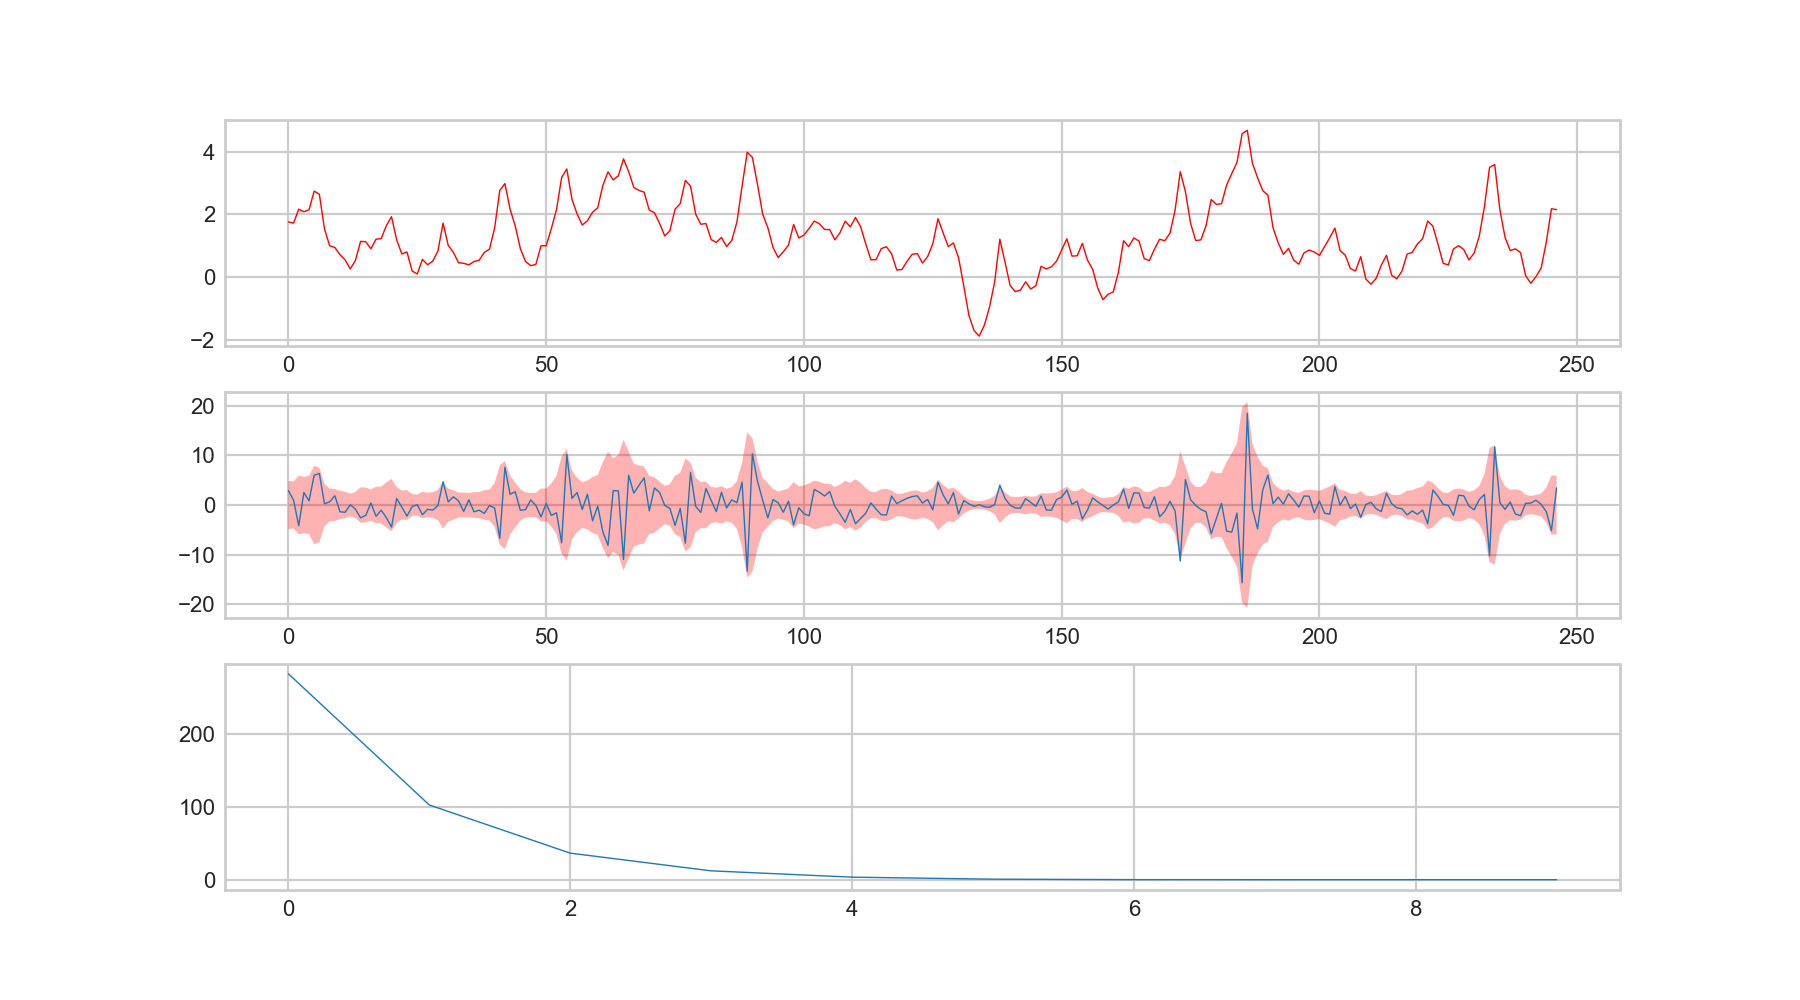

In [11]:
fig3, [ax1, ax2, ax3] = plt.subplots(3,1)

if sim_data == 1:
    ax1.plot(range(n_obs), x_true, linewidth=0.5)

ax1.plot(range(n_obs), x_est_nr, linewidth=0.5, color='r')
#ax1.plot(range(n_obs), np.log(np.power(y,2)), linewidth=0.5, color='g')

ax2.plot(range(n_obs), y, linewidth=0.5)
#plot the MAP est 2\sigma intervale for obs
ax2.fill_between(range(n_obs), -2*np.exp(x_est_nr/2), 2*np.exp(x_est_nr/2), alpha=0.3, facecolor='red')

#check the convergence of Newton's method
ax3.plot(range(n_steps), grad_norm, linewidth=0.5)

## Laplace approximation to the marginal likelihood
The idea is to approximate p(x_{0:n}, y_{0:n};\theta) by Taylor expansion about the MAP estimate:
$$
p(x_{0:n}, y_{0:n};\theta) = \exp[-U(x_{0:n})]=\exp\big[-U(x_{0:n})+U(x_{0:n}^\star)\big] p(x_{0:n}^\star, y_{0:n};\theta)\approx \exp\left(-\frac{1}{2}(x_{0:n}-x_{0:n}^\star)^T \Omega (x_{0:n}-x_{0:n}^\star)\right)p(x_{0:n}^\star, y_{0:n};\theta)
$$
where $\theta = (\alpha,\mu,\sigma)$ and:
$$
x^\star_{0:n} = \arg\max_{x_{0:n}} p(x_{0:n}, y_{0:n};\theta),\qquad \Omega = \frac{\partial^2 \log p(x_{0:n}^\star, y_{0:n};\theta)}{\partial x_{0:n} \partial x_{0:n}^\prime}.
$$
Hence
$$
p(y_{0:n};\theta) = \int p(x_{0:n}, y_{0:n};\theta)\, d x_{0:n} \approx |\det(\Omega)|^{-1/2}p(x^\star_{0:n}, y_{0:n};\theta),
$$

See, for instance: Skaug and Yu, "A flexible and automated likelihood based framework for inference in stochastic volatility models", Computational Statistics and Data Analysis, 76, August 2014, Pages 642-654.

In [12]:
def est_MAP(alpha,mu,sigma,y,n_obs,n_steps):
    
    inv_cov = build_inv_cov(n_obs, alpha, sigma)
    
    x_now = np.zeros(n_obs)
    grad_norm = np.zeros(n_steps)

    for i in range(n_steps):
        grad = eval_grad_U(x_now,y,mu,inv_cov,n_obs)
        hess = eval_hess_U(x_now,y,inv_cov,n_obs)
        grad_norm[i] = np.dot(grad,grad)**0.5
    
        x_next = x_now - spsolve(hess,grad)
        x_now = x_next
    
    return x_now        

In [13]:
def eval_U(x,alpha,mu,sigma,n_obs):

    inv_cov =  build_inv_cov(n_obs, alpha, sigma)
    U = n_obs*np.log(2*np.pi)+n_obs*np.log(sigma) + 0.5*(x-mu)@inv_cov@(x-mu) + 0.5*(sum(x) + np.dot(np.power(y,2),np.exp(-x)))
    
    return U

In [14]:
def max_marg_like(param_id,n_steps,n_grid,alpha,mu,sigma,y,n_obs):
    
    U = np.zeros(n_grid)
    log_marg_like = np.zeros(n_grid)
    
    if param_id == 'alpha': #so alpha is a grid of values, and mu, sigma are const.
        for i in range(n_grid):
            x_est = est_MAP(alpha[i],mu,sigma,y,n_obs,n_steps)
            U[i] = eval_U(x_est,alpha[i],mu,sigma,n_obs)
    
            #Laplace approximation to marg likelihood - see Skaug and Yu - "Automated likelihood based inference...stoch vol models"
            inv_cov =  build_inv_cov(n_obs, alpha[i], sigma)
            hess = eval_hess_U(x_est,y,inv_cov,n_obs)
            sign, logdet = np.linalg.slogdet(hess.todense())
            log_marg_like[i] = -0.5*logdet - U[i]
            
        id_max = np.argmax(log_marg_like)
        return alpha[id_max], log_marg_like
            
    elif param_id == 'mu':
        for i in range(n_grid):
            x_est = est_MAP(alpha,mu[i],sigma,y,n_obs,n_steps)
            U[i] = eval_U(x_est,alpha,mu[i],sigma,n_obs)
    
            #Laplace approximation to marg likelihood - see Skaug and Yu - "Automated likelihood based inference...stoch vol models"
            inv_cov =  build_inv_cov(n_obs, alpha, sigma)
            hess = eval_hess_U(x_est,y,inv_cov,n_obs)
            sign, logdet = np.linalg.slogdet(hess.todense())
            log_marg_like[i] = -0.5*logdet - U[i]
            
        id_max = np.argmax(log_marg_like)
        return mu[id_max], log_marg_like
            
    elif param_id == 'sigma':
        for i in range(n_grid):
            x_est = est_MAP(alpha,mu,sigma[i],y,n_obs,n_steps)
            U[i] = eval_U(x_est,alpha,mu,sigma[i],n_obs)
    
            #Laplace approximation to marg likelihood - see Skaug and Yu - "Automated likelihood based inference...stoch vol models"
            inv_cov =  build_inv_cov(n_obs, alpha, sigma[i])
            hess = eval_hess_U(x_est,y,inv_cov,n_obs)
            sign, logdet = np.linalg.slogdet(hess.todense())
            log_marg_like[i] = -0.5*logdet - U[i]
            
        id_max = np.argmax(log_marg_like)
        return sigma[id_max], log_marg_like
                

## Maximum marginal likelihood via Laplace approximation and co-ordinate ascent



In [15]:
sim_data = 0
y = np.loadtxt("residuals_monthly.csv", delimiter=",")



Current progress: 100.0 %


<IPython.core.display.Javascript object>


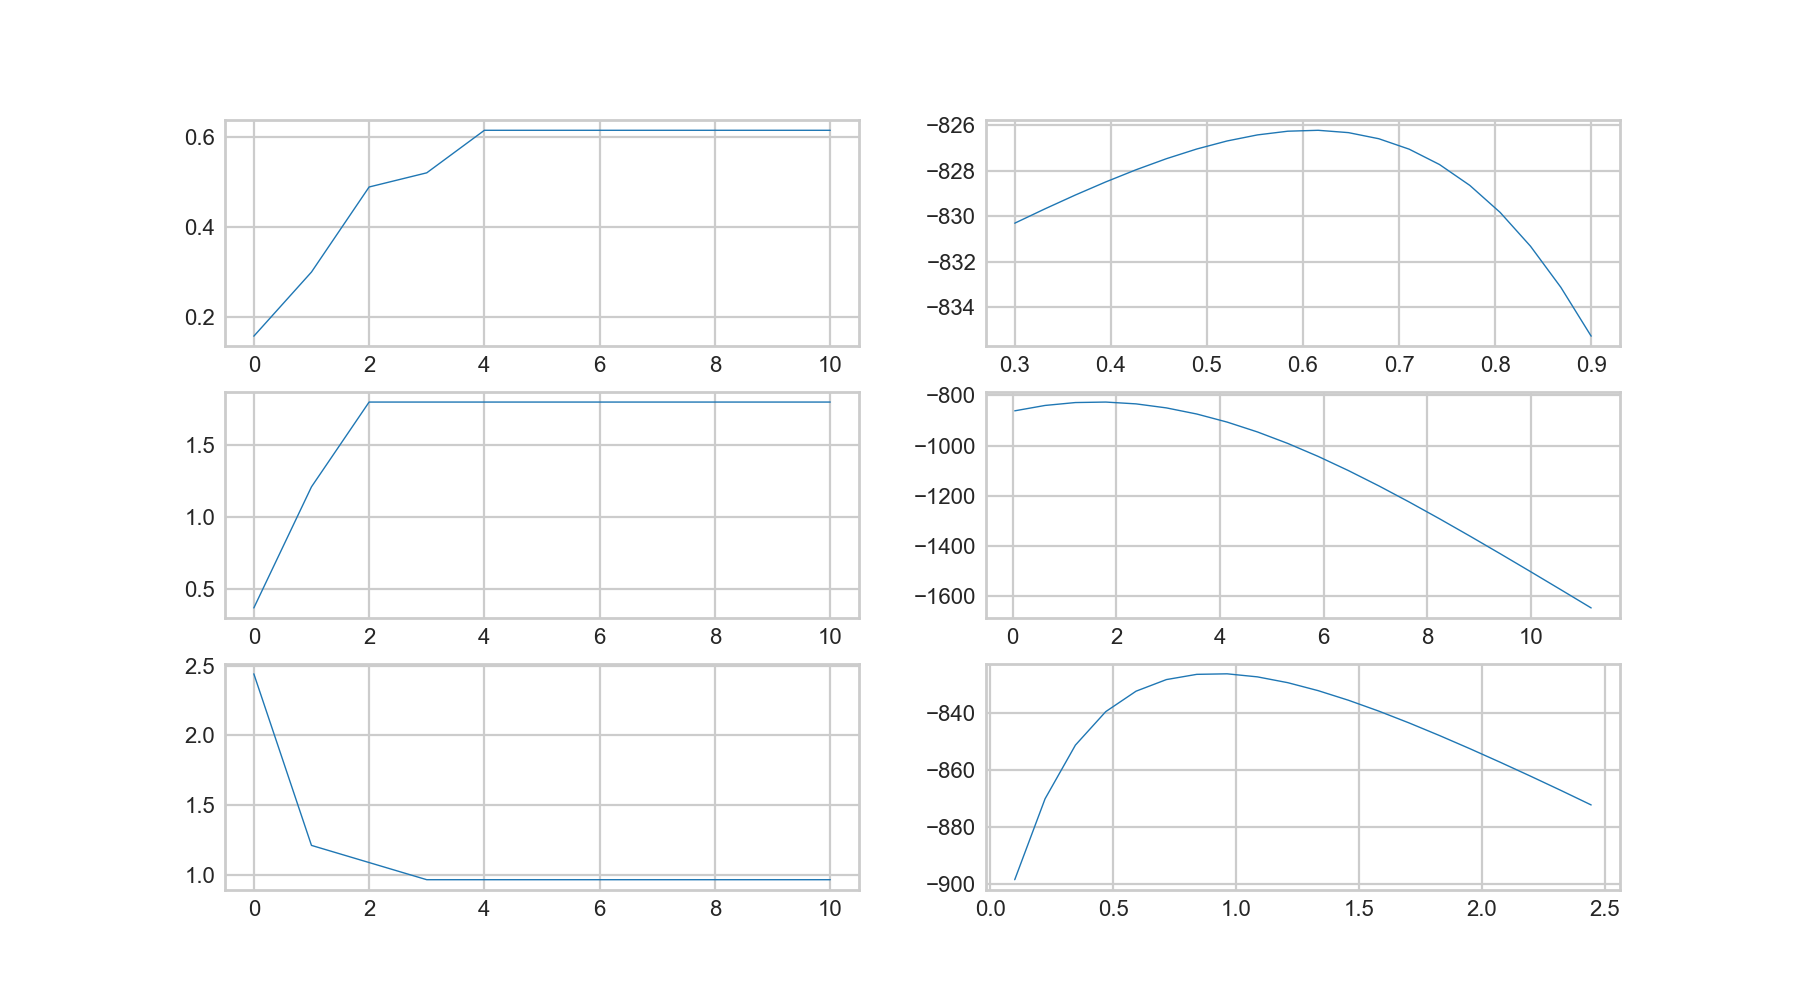

In [16]:

n_cycles = 10 #numbe of cycles through the parameters
n_obs = y.size

alpha_est = np.zeros(n_cycles+1)
mu_est = np.zeros(n_cycles+1)
sigma_est = np.zeros(n_cycles+1)

#initial guesses based on data
alpha_est[0], mu_est[0], sigma_est[0] = est_params(np.log(np.power(y,2)))

#set up grids on which to evaluate marginal likelihood
#n_grid = 10
#alpha_grid = np.linspace(0.3,0.9,n_grid)
#mu_grid = np.linspace(0.1*mu_est[0],3*mu_est[0],n_grid)
#sigma_grid = np.linspace(0.1,sigma_est[0],n_grid)

#set up grids on which to evaluate marginal likelihood
n_grid = 20
alpha_grid = np.linspace(0.3,0.9,n_grid)
mu_grid = np.linspace(0.1*mu_est[0],30*mu_est[0],n_grid)
sigma_grid = np.linspace(0.1,sigma_est[0],n_grid)

#number of Newton steps per parameter value
n_steps = 5

#cycle through the parameter updates : coordinate-ascent
for i in range(1,n_cycles+1):
    
    clear_output(wait=True)
    
    alpha_est[i], lml_alpha = max_marg_like('alpha',n_steps,n_grid,alpha_grid,mu_est[i-1],sigma_est[i-1],y,n_obs)
    mu_est[i], lml_mu = max_marg_like('mu',n_steps,n_grid,alpha_est[i],mu_grid,sigma_est[i-1],y,n_obs)
    sigma_est[i], lml_sigma = max_marg_like('sigma',n_steps,n_grid,alpha_est[i],mu_est[i],sigma_grid,y,n_obs)
    
    print("Current progress:", np.round(i/n_cycles, 2)*100, "%")

#plot the evolution of the estimates and the log_marg_likes from the final iteration
fig6, ax = plt.subplots(3,2)
ax[0,0].plot(range(n_cycles+1),alpha_est,linewidth=0.5)
ax[0,1].plot(alpha_grid,lml_alpha,linewidth=0.5)
ax[1,0].plot(range(n_cycles+1),mu_est,linewidth=0.5)
ax[1,1].plot(mu_grid,lml_mu,linewidth=0.5)
ax[2,0].plot(range(n_cycles+1),sigma_est,linewidth=0.5)
ax[2,1].plot(sigma_grid,lml_sigma,linewidth=0.5)




    

In [53]:
np.savetxt("SV_params_monthly.csv", [alpha_est[n_cycles], mu_est[n_cycles], sigma_est[n_cycles]], delimiter=",")
#np.savetxt("SV_params_daily.csv", [alpha_est[n_cycles], mu_est[n_cycles], sigma_est[n_cycles]], delimiter=",")

<IPython.core.display.Javascript object>


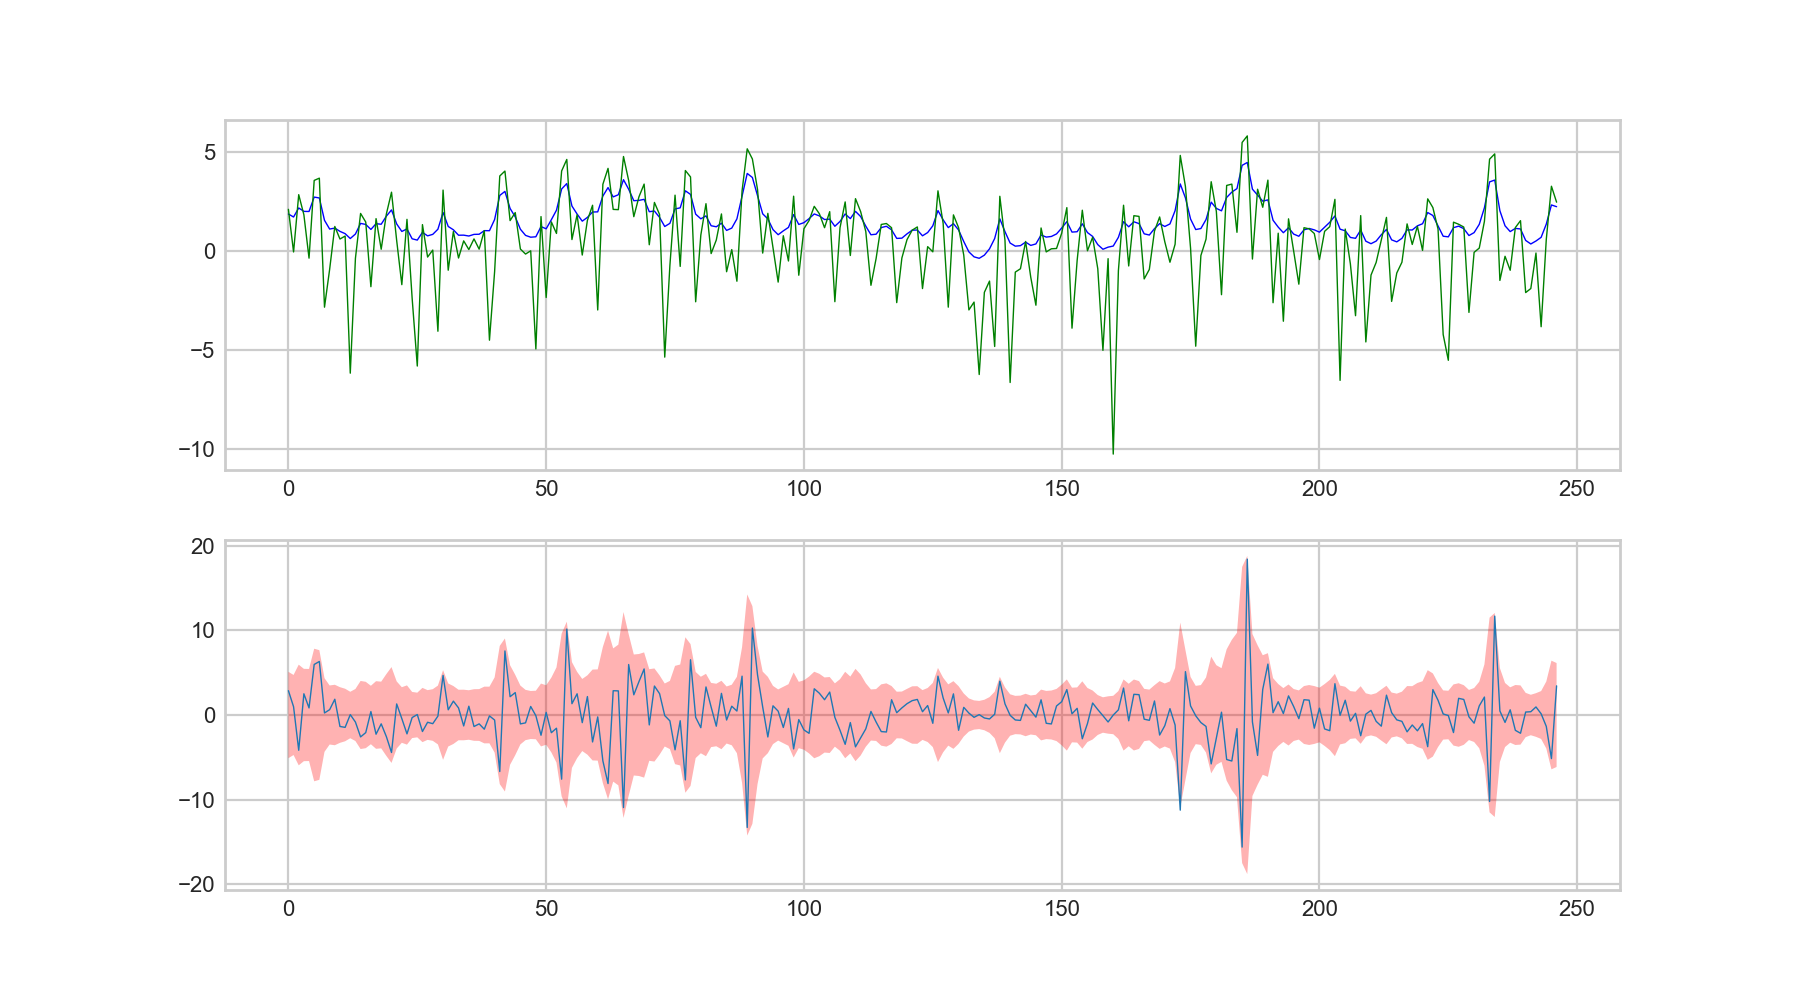

In [17]:
#after estimating the AR(1) parameters, plot the MAP estimate
alpha, mu, sigma = np.loadtxt("SV_params_monthly.csv", delimiter=",")


y = np.loadtxt("residuals_monthly.csv", delimiter=",")
n_obs = y.size
n_steps = 10
x_est_opt = est_MAP(alpha,mu,sigma,y,n_obs,n_steps)
np.savetxt("x_est_monthly.csv", x_est_opt, delimiter=",")

fig7, [ax1, ax2] = plt.subplots(2,1)

ax1.plot(range(n_obs), x_est_opt, linewidth=0.5, color='b')
ax1.plot(range(n_obs), np.log(np.power(y,2)), linewidth=0.5, color='g')
ax2.plot(range(n_obs), y, linewidth=0.5)
ax2.fill_between(range(n_obs), -2*np.exp(x_est_opt/2), 2*np.exp(x_est_opt/2), alpha=0.3, facecolor='red')

In [55]:
print(alpha)

0.6157894736842107


In [56]:
print(mu)

1.7941836967929254


In [57]:
print(sigma)

0.9632886539726895
